<a href="https://colab.research.google.com/github/erlonL/series-temporais/blob/main/projeto2/ST_Projeto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install yfinance snscrape pandas_market_calendars pandas_datareader lazypredict

In [47]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_market_calendars as mcal
import pandas_datareader.data as web
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # ou outro modelo de regressão
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
new_model = pipeline(
    model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
    return_all_scores=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


## ETAPA 1: Coleta e Tratamento de Dados

S&P 500, abreviação de Standard & Poor's 500, ou simplesmente S&P, trata-se de um índice composto por quinhentos ativos cotados nas bolsas de NYSE ou NASDAQ, qualificados devido ao seu tamanho de mercado, sua liquidez e sua representação de grupo industrial.

In [4]:
# Defina o ticker para o índice S&P 500
ticker = '^BVSP'

# Crie um objeto Ticker
index = yf.Ticker(ticker)

# Defina o intervalo de datas
start_date = '2020-01-01'
end_date = '2024-08-31'

# Obtenha os dados históricos
data = index.history(start=start_date, end=end_date)

# deixar apenas a data (y/m/d) na coluna date
data.index = data.index.date

# Exiba os primeiros registros para verificação
print(data.head())

                Open      High       Low     Close   Volume  Dividends  \
2020-01-02  115652.0  118573.0  115649.0  118573.0  5162700        0.0   
2020-01-03  118564.0  118792.0  117341.0  117707.0  6834500        0.0   
2020-01-06  117707.0  117707.0  116269.0  116878.0  6570000        0.0   
2020-01-07  116872.0  117076.0  115965.0  116662.0  4854100        0.0   
2020-01-08  116667.0  117335.0  115693.0  116247.0  5910500        0.0   

            Stock Splits  
2020-01-02           0.0  
2020-01-03           0.0  
2020-01-06           0.0  
2020-01-07           0.0  
2020-01-08           0.0  


No artigo, foi filtrado os dados para os dias úteis do mercado. Faremos a seguir esse processamento:

In [5]:
nyse = mcal.get_calendar('NYSE')

dias_uteis = nyse.valid_days(start_date=start_date, end_date=end_date)

# Pegar so a data
dias_uteis = [dia.date() for dia in dias_uteis]

In [6]:
sp500 = data.loc[data.index.intersection(dias_uteis)]

print(sp500.head())

sp500.to_csv("sp500.csv")

                Open      High       Low     Close   Volume  Dividends  \
2020-01-02  115652.0  118573.0  115649.0  118573.0  5162700        0.0   
2020-01-03  118564.0  118792.0  117341.0  117707.0  6834500        0.0   
2020-01-06  117707.0  117707.0  116269.0  116878.0  6570000        0.0   
2020-01-07  116872.0  117076.0  115965.0  116662.0  4854100        0.0   
2020-01-08  116667.0  117335.0  115693.0  116247.0  5910500        0.0   

            Stock Splits  
2020-01-02           0.0  
2020-01-03           0.0  
2020-01-06           0.0  
2020-01-07           0.0  
2020-01-08           0.0  


In [7]:
sp500.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1132.000000,1132.000000,1132.000000,1132.000000,1.132000e+03,1132.0,1132.0
mean,112369.626325,113391.765018,111349.559187,112379.494700,1.088641e+07,0.0,0.0
std,12449.948162,12175.207027,12711.117183,12471.697703,3.288929e+06,0.0,0.0
min,63604.000000,67604.000000,61691.000000,63570.000000,0.000000e+00,0.0,0.0
25%,105070.750000,106133.250000,103905.500000,105070.750000,8.897975e+06,0.0,0.0
50%,113581.500000,114462.000000,112550.000000,113576.000000,1.071815e+07,0.0,0.0
75%,120307.750000,121275.250000,119408.500000,120379.750000,1.268675e+07,0.0,0.0
max,137349.000000,137469.000000,136664.000000,137344.000000,2.602930e+07,0.0,0.0


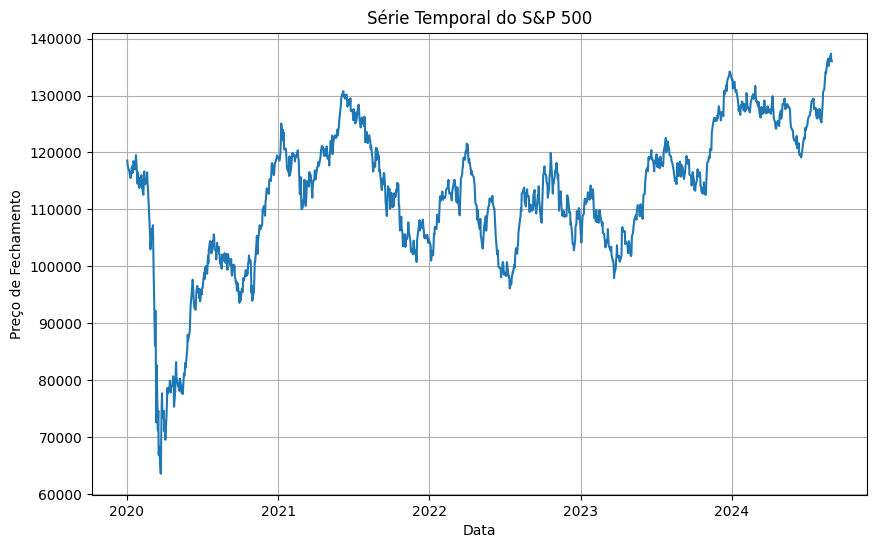

In [32]:
# plotando a serie temporal de sp500
plt.figure(figsize=(10, 6))
plt.plot(sp500['Close'])
plt.title('Série Temporal do S&P 500')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.grid(True)
plt.show()

In [20]:
df_labeled = pd.read_csv("/content/labeled_News_dataset.csv")
df_articles = pd.read_csv("/content/stock_data_articles.csv")

In [21]:
df_labeled.rename(columns={'title': 'Title'}, inplace=True)
df_labeled.head()

,Title,text,label
0,Stocks making the biggest moves midday: Palo A...,A view of the exterior of the new Dutch head o...,-2
1,3M will spin off its health-care business into...,3M announced Tuesday it will spin off its heal...,-2
2,"Stocks making the biggest moves midday: 3M, Pa...",A woman walks near a Bed Bath & Beyond branch ...,0
3,"3M to cut 2,500 jobs as demand weakens, profit...",An employee unboxes N95 masks as part of a gov...,0
4,"3M combat earplug lawsuits to proceed, judge r...","3M must face more than 230,000 lawsuits accusi...",-2


In [22]:
# remover os dados datados antes de 2020-01-01
df_articles = df_articles[df_articles['Publishdate'] >= '2020-01-01']
df_articles.head()

,Unnamed: 0,links,symbol,company,Title,Text,Publishdate
0,0,https://www.cnbc.com/2023/06/05/stocks-making-...,MMM,3M,Stocks making the biggest moves midday: Palo A...,A view of the exterior of the new Dutch head o...,2023-06-05
1,1,https://www.cnbc.com/2022/07/26/3m-will-spin-o...,MMM,3M,3M will spin off its health-care business into...,3M announced Tuesday it will spin off its heal...,2022-07-26
2,2,https://www.cnbc.com/2023/01/24/stocks-making-...,MMM,3M,"Stocks making the biggest moves midday: 3M, Pa...",A woman walks near a Bed Bath & Beyond branch ...,2023-01-24
3,3,https://www.cnbc.com/2023/01/24/3m-to-cut-2500...,MMM,3M,"3M to cut 2,500 jobs as demand weakens, profit...",An employee unboxes N95 masks as part of a gov...,2023-01-24
4,4,https://www.cnbc.com/2022/08/26/3m-combat-earp...,MMM,3M,"3M combat earplug lawsuits to proceed, judge r...","3M must face more than 230,000 lawsuits accusi...",2022-08-26


In [23]:
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2621 entries, 0 to 4588
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   2621 non-null   int64 
 1   links        2621 non-null   object
 2   symbol       2621 non-null   object
 3   company      2621 non-null   object
 4   Title        2621 non-null   object
 5   Text         2621 non-null   object
 6   Publishdate  2621 non-null   object
dtypes: int64(1), object(6)
memory usage: 228.4+ KB


In [24]:
labeled_articles = pd.merge(df_labeled, df_articles[['Title', 'Publishdate']], on='Title', how='left')
labeled_articles.head()

,Title,text,label,Publishdate
0,Stocks making the biggest moves midday: Palo A...,A view of the exterior of the new Dutch head o...,-2,2023-06-05
1,3M will spin off its health-care business into...,3M announced Tuesday it will spin off its heal...,-2,2022-07-26
2,"Stocks making the biggest moves midday: 3M, Pa...",A woman walks near a Bed Bath & Beyond branch ...,0,2023-01-24
3,"3M to cut 2,500 jobs as demand weakens, profit...",An employee unboxes N95 masks as part of a gov...,0,2023-01-24
4,"3M combat earplug lawsuits to proceed, judge r...","3M must face more than 230,000 lawsuits accusi...",-2,2022-08-26


In [25]:
labeled_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5036 entries, 0 to 5035
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        5036 non-null   object
 1   text         5036 non-null   object
 2   label        5036 non-null   int64 
 3   Publishdate  3113 non-null   object
dtypes: int64(1), object(3)
memory usage: 157.5+ KB


In [26]:
labeled_articles.dropna(inplace=True)
labeled_articles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3113 entries, 0 to 5035
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        3113 non-null   object
 1   text         3113 non-null   object
 2   label        3113 non-null   int64 
 3   Publishdate  3113 non-null   object
dtypes: int64(1), object(3)
memory usage: 121.6+ KB


In [27]:
labeled_articles['Publishdate'] = pd.to_datetime(labeled_articles['Publishdate'])

sp500['Date'] = pd.to_datetime(sp500.index)

In [28]:
# juntar os dados com data em comum de labeled_articles e sp500['Close']
labeled_close = pd.merge(labeled_articles, sp500[['Date', 'Close']], left_on='Publishdate', right_on='Date', how='left')
labeled_close.head()

,Title,text,label,Publishdate,Date,Close
0,Stocks making the biggest moves midday: Palo A...,A view of the exterior of the new Dutch head o...,-2,2023-06-05,2023-06-05,112696.0
1,3M will spin off its health-care business into...,3M announced Tuesday it will spin off its heal...,-2,2022-07-26,2022-07-26,99772.0
2,"Stocks making the biggest moves midday: 3M, Pa...",A woman walks near a Bed Bath & Beyond branch ...,0,2023-01-24,2023-01-24,113028.0
3,"3M to cut 2,500 jobs as demand weakens, profit...",An employee unboxes N95 masks as part of a gov...,0,2023-01-24,2023-01-24,113028.0
4,"3M combat earplug lawsuits to proceed, judge r...","3M must face more than 230,000 lawsuits accusi...",-2,2022-08-26,2022-08-26,112299.0


In [30]:
# remover as colunas title text e publishdate
labeled_close.drop(['Title', 'text', 'Publishdate'], axis=1, inplace=True)
labeled_close.head()

,label,Date,Close
0,-2,2023-06-05,112696.0
1,-2,2022-07-26,99772.0
2,0,2023-01-24,113028.0
3,0,2023-01-24,113028.0
4,-2,2022-08-26,112299.0


In [31]:
# Normalizando a coluna 'Close'
labeled_close['Close'] = (labeled_close['Close'] - labeled_close['Close'].min()) / (labeled_close['Close'].max() - labeled_close['Close'].min())
labeled_close.head()

,label,Date,Close
0,-2,2023-06-05,0.680560
1,-2,2022-07-26,0.488521
2,0,2023-01-24,0.685493
3,0,2023-01-24,0.685493
4,-2,2022-08-26,0.674661


In [41]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.8 MB/s eta 0:00:00


In [42]:
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import clear_output

In [50]:
# transformando em int o valor da coluna 'Date'
labeled_close['Date'] = labeled_close['Date'].astype(int)

In [53]:
labeled_close.dropna(inplace=True)

In [54]:
X = labeled_close[['Date', 'label']]
y = labeled_close['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
model = RandomForestRegressor()  # ou outro modelo de regressão
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Mean Squared Error: 8.47840417442479e-05
R² Score: 0.9969872181370659


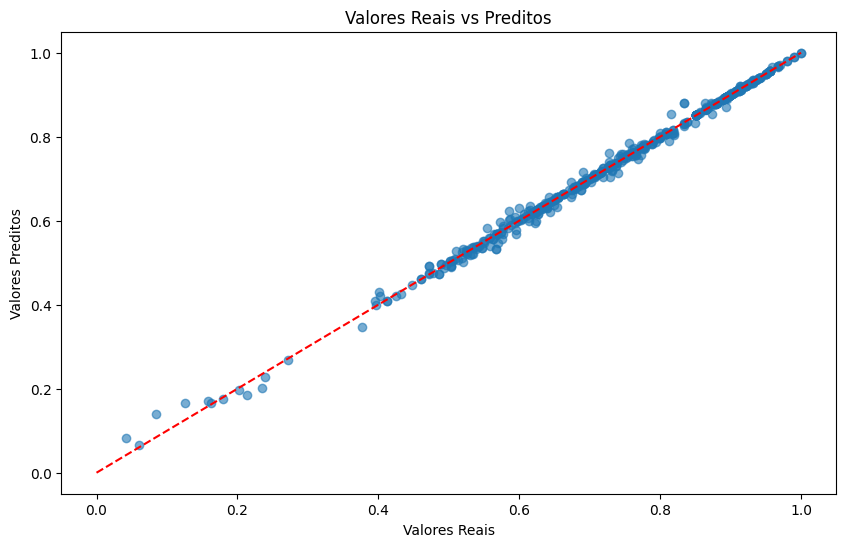

In [56]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

# Opcional: Visualizar as predições versus os valores reais
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais vs Preditos')
plt.show()